In [28]:
from PIL import Image
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
from IPython.display import display
from io import BytesIO
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").cuda()
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
dataset = load_dataset("danjacobellis/aria_ea_rgb_100k")

Resolving data files:   0%|          | 0/70 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/70 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/83 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/18 [00:00<?, ?it/s]

In [3]:
classes = [
    "kitchen",
    "cooking",
    "food",
    "drink",
    "spill",
    "table",
    "television",
    "phone",
    "laptop",
    "video game",
    "board game",
    "clothes",
    "laundry",
]

In [4]:
def get_clip(sample):
    with torch.no_grad():
        image = sample['image']
        inputs = processor(text=classes, images=image, return_tensors="pt", padding=True)
        for k in inputs.keys():
            if hasattr(inputs[k], "device"):
                inputs[k] = inputs[k].cuda()
        outputs = model(**inputs)
        sample['clip_logit'] = outputs.logits_per_image
        return sample

In [294]:
clip_dataset = dataset['validation'].map(get_clip);
clip_logit = clip_dataset.with_format("torch")['clip_logit']

In [292]:
def jpeg_compress(img, rr=3, subsampling=0, quality=5):
    w = img.width
    h = img.height
    with BytesIO() as f:
        img = img.resize((w//rr,h//rr))
        img = img.save(f,
                       format='JPEG',
                       subsampling=subsampling,
                       quality=quality
                      )
        img = f.getvalue()
    bpp = 8*len(img)/(w*h)
    img = Image.open(BytesIO(img)).resize((w,h))
    return img,bpp

In [295]:
def get_clip_jpeg(sample):
    with torch.no_grad():
        image, bpp = jpeg_compress(sample['image'])
        inputs = processor(text=classes, images=image, return_tensors="pt", padding=True)
        for k in inputs.keys():
            if hasattr(inputs[k], "device"):
                inputs[k] = inputs[k].cuda()
        outputs = model(**inputs)
        sample['clip_logit'] = outputs.logits_per_image
        return sample

In [297]:
jpeg_dataset = dataset['validation'].map(get_clip_jpeg)
jpeg_clip_logit = jpeg_dataset.with_format("torch")['clip_logit']
jpeg_dataset

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label', 'clip_logit'],
    num_rows: 20000
})

In [298]:
for i_img in range(0,20000,1000):
    img = dataset['validation'][i_img]['image']
    logit = jpeg_clip_logit[i_img]['clip_logit'][0]
    ind = np.argmax(logit)
    if logit[ind]>18:
        print(classes[ind])
        display(img.rotate(-90).resize((256,256)))

IndexError: too many indices for tensor of dimension 2

clothes


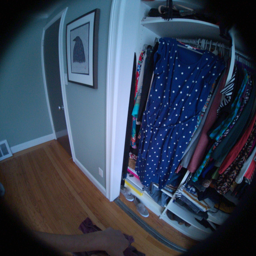

television


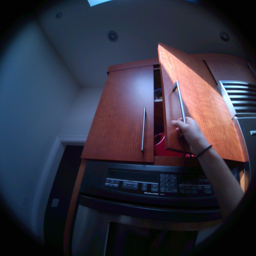

television


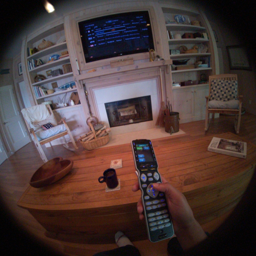

phone


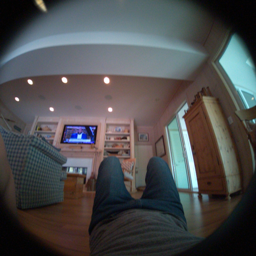

video game


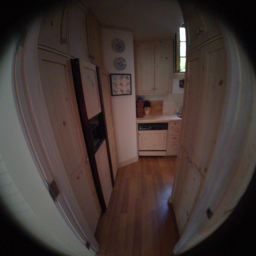

television


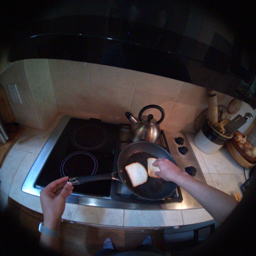

television


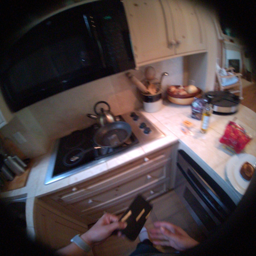

table


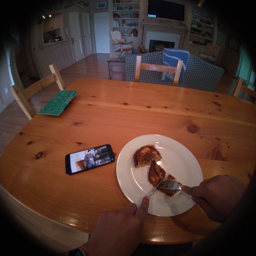

phone


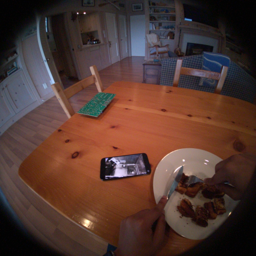

laptop


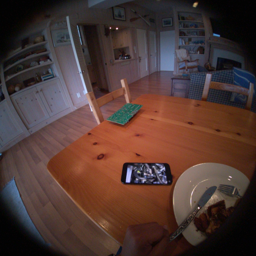

laptop


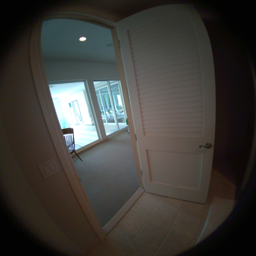

table


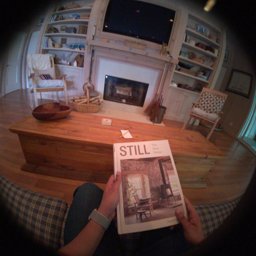

table


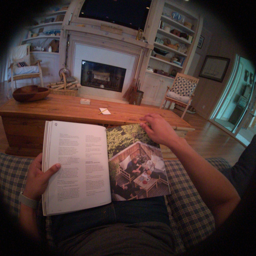

television


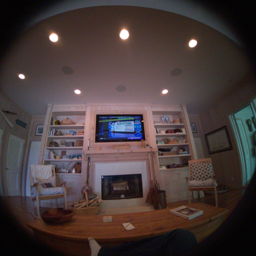

phone


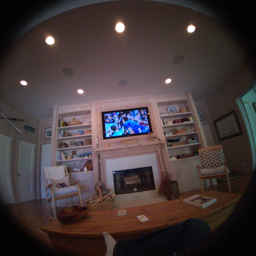

laptop


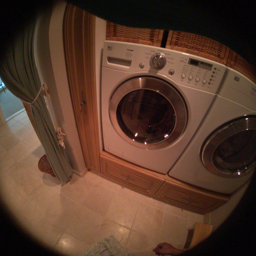

video game


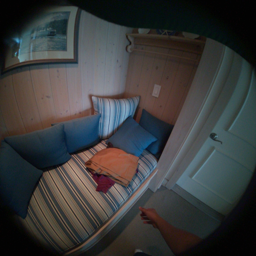

video game


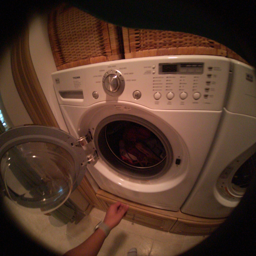

laundry


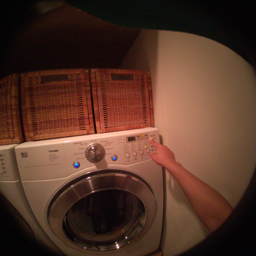

phone


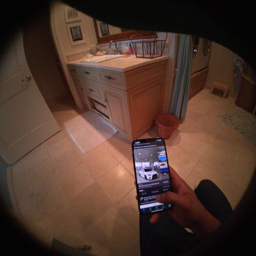

In [299]:
for i_img in range(0,20000,1000):
    img = dataset['validation'][i_img]['image']
    logit = jpeg_dataset[i_img]['clip_logit'][0]
    ind = np.argmax(logit)
    if logit[ind]>18:
        print(classes[ind])
        display(img.rotate(-90).resize((256,256)))